# Scheduling with optional tasks
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/optional_tasks.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

This notebook demonstrates how to solve scheduling problems with _optional_ tasks. 

Optional tasks appear in practice when products can be built following different processing plans. Each plan may require a different number of tasks, each task having specific dependencies or constraints. For example, a product could be built by building steps `A` followed by `B`, which require two different resources, or simply through step `C`, requiring one resource but with higher demand.

Scheduling with optional tasks introduces the additional decision _which_ tasks to schedule. This type of problem is known in the scheduling literature under different names:
- Alternative process plans [(Kis, 2003)](https://www.sciencedirect.com/science/article/pii/S0377221702008287)
- Distributed scheduling [(Naderi and Ruiz, 2010)](https://www.sciencedirect.com/science/article/pii/S0305054809001786)
- Scheduling with rejections [(Shabtay et al., 2013)](https://link.springer.com/article/10.1007/s10951-012-0303-z)
- Flexible project structures [(Kellenbrink and Helber, 2015)](http://refhub.elsevier.com/S0377-2217(24)00826-9/sb6)

We will show how to define scheduling problems with optional tasks, and how to use selection constraints to solve complex versions of this problem.

## Setting optional tasks

Let's define the simple example problem that we described.

In [30]:
from pyjobshop import Model

In [31]:
model = Model()

machine = model.add_machine()

A = model.add_task(optional=True, name="A")
B = model.add_task(optional=True, name="B")
C = model.add_task(optional=True, name="C")

model.add_mode(A, machine, duration=1)
model.add_mode(B, machine, duration=1)
model.add_mode(C, machine, duration=3);

Next, we need to specify _how_ to select the tasks. PyJobShop supports a set of selection constraints (see next section for an overview), which provides a simple way to declare your problem's selection logic. This problem can be specified as follows:

In [32]:
model.add_select_at_least_one([A, C])  # Either A or C is scheduled
model.add_select_all_or_none([A, B]);  # A and B are both present or absent

In addition, if A is scheduled, then it must be scheduled before B:

In [33]:
model.add_end_before_start(A, B);

Now let's solve this problem instance and plot the solution.

In [34]:
result = model.solve(display=False)

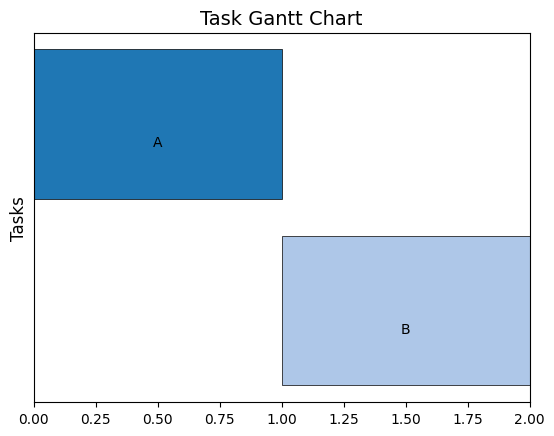

In [35]:
from pyjobshop.plot import plot_task_gantt

plot_task_gantt(result.best, model.data(), plot_labels=True)

Great, this solves the problem as expected! Tasks A and B are scheduled because this is obviously shorter than scheduling C. 

Of course, this was just a simple toy problem. In realistic problems, task C might use a resource that is always available, whereas A and B could require a bottleneck machine. This would then favor scheduling task C.

## Selection constraints

PyJobShop implements the following selection constraints:
- `SelectAllOrNone`
- `SelectAtLeastOne`
- `SelectExactlyOne`

These selection constraints are provided to provide a complete yet compact set of constraints to define problems involving optional tasks.

## Advanced if-then constraints

Processing plans can become very complex: Take this problem from [Van der Beek et al. (2025)](https://www.sciencedirect.com/science/article/pii/S0377221724008269) for example.
In very flexible cases, there are many dependencies between optional tasks. The diagram below illustrates two graphs: a selection graph, which dictates the selection tasks and subsequent tasks, and a precedence graph, which dictates the precedence between tasks, if present.

![example](../assets/van-der-beek-selection.jpg)

Let's model this specific example, which defines how tasks `C-A`, `C-B`, `C-AB`, `I-A`, `I-AB`, and `I-B` can be selected based on the presence of others.

In [78]:
model = Model()

First, we have a `source` task marking the beginning of the project and a `target` task marking the end. These are typically required tasks. We also define all other tasks, which are all optional.

In [79]:
tasks = {"source": model.add_task(name="source")}

names = ["C-A", "C-B", "C-AB", "I-A", "I-AB", "I-B"]
tasks |= {name: model.add_task(optional=True, name=name) for name in names}

tasks["target"] = model.add_task(name="target")

For convenience, we assume there is a single resource, and that each optional task takes 1 duration, whereas the source and target tasks require zero duration.

In [80]:
machine = model.add_machine()

model.add_mode(tasks["source"], machine, duration=0)
model.add_mode(tasks["target"], machine, duration=0)

for name in names:
    model.add_mode(tasks[name], machine, duration=1)

Starting from the `source` task, both `C-A` or `C-B` must be selected. 

In [83]:
model.add_select_exactly_one([tasks["C-A"]], trigger_task=tasks["source"])
model.add_select_exactly_one([tasks["C-B"]], trigger_task=tasks["source"])
model.add_end_before_start(tasks["source"], tasks["C-A"])
model.add_end_before_start(tasks["source"], tasks["C-B"]);

If task `C-A` is selected, then you must choose exactly one of `C-AB` or `I-A`. This means that after `C-A`, the process can either go through a common converging path (`C-AB`) or a specific intermediate task (`I-A`).

In [84]:
model.add_select_exactly_one(
    [tasks["C-AB"], tasks["I-A"]], trigger_task=tasks["C-A"]
)
model.add_end_before_start(tasks["C-A"], tasks["C-AB"])
model.add_end_before_start(tasks["C-A"], tasks["I-A"])
model.add_end_before_start(tasks["I-A"], tasks["I-B"]);

Similarly, if task `C-B` is selected, then you must choose exactly one of `C-AB` or `I-B`. This mirrors the `C-A` logic but for the `C-B` branch.

In [85]:
model.add_select_exactly_one(
    [tasks["C-AB"], tasks["I-B"]], trigger_task=tasks["C-B"]
)
model.add_end_before_start(tasks["C-B"], tasks["C-AB"])
model.add_end_before_start(tasks["C-B"], tasks["I-B"]);

If `C-AB` is chosen (either from `C-A` or `C-B`), then `I-AB` *must* also be chosen. This indicates `C-AB` is a prerequisite for `I-AB`.

In [86]:
model.add_select_exactly_one([tasks["I-AB"]], trigger_task=tasks["C-AB"])
model.add_end_before_start(tasks["C-AB"], tasks["I-AB"]);

In [87]:
model.add_end_before_start(tasks["I-A"], tasks["target"])
model.add_end_before_start(tasks["I-B"], tasks["target"])
model.add_end_before_start(tasks["I-AB"], tasks["target"]);

The `trigger_task` task parameter in PyJobShop's selection constraints (`SelectAllOrNone`, `SelectAtLeastOne`, `SelectExactlyOne`) is crucial for modeling these "if-then" relationships. 
It ensures that a given selection constraint is only enforced if its `condition` task is present in the schedule. 
This allows for highly flexible and dynamic processing plans, where the set of tasks to be scheduled is not fixed but rather depends on strategic choices made during the scheduling process.

In [88]:
result = model.solve(display=False)

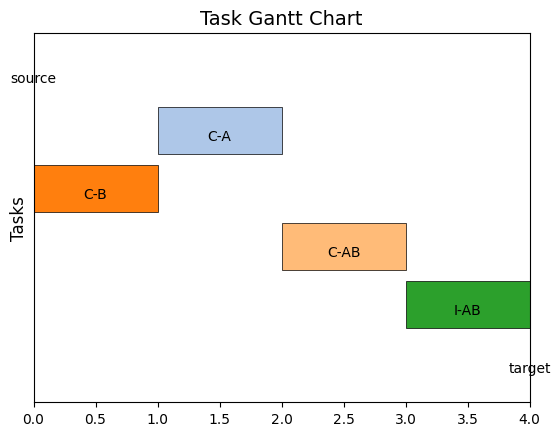

In [89]:
plot_task_gantt(result.best, model.data(), plot_labels=True)